In [2]:
%matplotlib inline

In [29]:
import pandas as pd
import glob
import numpy as np
from datetime import datetime

from zipfile import ZipFile as ZF
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons

from spread import variance, standard_deviation, zipped_z_scores
from stats import mean
from scipy import stats

In [4]:
data_dir = "../data/_rawdata"
lookup_path = "../data/_rawdata/lookup"
lookup_file = "DEFS2009.xls"
images_dir = "../images"

In [5]:
accident_DF = pd.DataFrame()
accident_aux_DF = pd.DataFrame()


In [6]:
accident_DF = pd.read_csv(os.path.join(data_dir, "accident_allyears.csv"))
accident_DF.columns

Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERNOTMVIT', 'PERMVIT', 'PERSONS', 'COUNTY', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'NHS', 'RUR_URB', 'FUNC_SYS',
       'RD_OWNER', 'ROUTE', 'TWAY_ID', 'TWAY_ID2', 'MILEPT', 'LATITUDE',
       'LONGITUD', 'SP_JUR', 'HARM_EV', 'MAN_COLL', 'RELJCT1', 'RELJCT2',
       'TYP_INT', 'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'SCH_BUS', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR',
       'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'CF1', 'CF2', 'CF3', 'FATALS',
       'DRUNK_DR'],
      dtype='object')

In [7]:
accident_aux_DF = pd.read_csv(os.path.join(data_dir, "accident_aux_allyears.csv"))

In [8]:
# Read Lookup data into lookup dataframe for HOUR, MINUTE and DAY_WEEK
hour_DF = pd.read_excel(os.path.join(lookup_path, lookup_file), "HOUR")
# Rename column ID to HOUR and DEF to HOUR_DEF
hour_DF.rename(columns = {"ID" : "HOUR","Def" : "HOUR_DEF" }, inplace = True)

min_DF = pd.read_excel(os.path.join(lookup_path, lookup_file), "MINUTE")
# Rename column ID to HOUR and DEF to HOUR_DEF
min_DF.rename(columns = {"ID" : "MINUTE","DEF" : "MINUTE_DEF" }, inplace = True)

day_week_DF = pd.read_excel(os.path.join(lookup_path, lookup_file), "DAY_WEEK")
# Rename column ID to HOUR and DEF to HOUR_DEF
day_week_DF.rename(columns = {"ID" : "DAY_WEEK","Def" : "DAY_WEEK_DEF" }, inplace = True)

In [9]:
accident_DF['ACC_DATE'] = accident_DF['YEAR'].astype(str) + \
                            "-"+accident_DF['MONTH'].astype(str) + \
                            "-"+accident_DF['DAY'].astype(str)
accident_DF["ACC_DATE"] = accident_DF["ACC_DATE"].apply(lambda r: datetime.strptime(r , '%Y-%m-%d'))

accident_DF['ACC_DATE'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-04
4   2015-01-07
Name: ACC_DATE, dtype: datetime64[ns]

In [10]:
accident_DF['ACC_DATE'][100].week

11

In [11]:
accident_DF["ACC_WEEK_NUM"] = accident_DF["ACC_DATE"].apply(lambda r : r.week)
accident_DF["ACC_WEEK_NUM"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 13, 15, 16, 17,
       18, 19, 21, 20, 22, 23, 24, 25, 26, 27, 28, 31, 30, 29, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 49, 51,
       52, 53], dtype=int64)

In [12]:
# Calculate Fatal accidents by month-year
ft_byMnth_Yr = accident_DF[["MONTH","YEAR","FATALS"]].groupby(["YEAR","MONTH"]).agg(np.sum)
ft_byMnth_Yr.reset_index(inplace = True)
ft_byMnth_Yr.head()

,YEAR,MONTH,FATALS
0,2015,1,2577
1,2015,2,2168
2,2015,3,2625
3,2015,4,2652
4,2015,5,3136


In [13]:
ft_2015 = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2015]
ft_2016 = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2016]
ft_2017 = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2017]

In [30]:
#Std dev for all years

print(f"STD DEV for FY2015 is {standard_deviation(ft_2015.FATALS)}")
print(f"STD DEV for FY2016 is {standard_deviation(ft_2016.FATALS)}")
print(f"STD DEV for FY2017 is {standard_deviation(ft_2017.FATALS)}")

print(f"Mean for FY2015 is {mean(ft_2015.FATALS)}")
print(f"Mean for FY2016 is {mean(ft_2016.FATALS)}")
print(f"mean for FY2017 is {mean(ft_2017.FATALS)}")



STD DEV for FY2015 is 352.75676227867456
STD DEV for FY2016 is 297.893297451733
STD DEV for FY2017 is 253.8777456222231
Mean for FY2015 is 2957.0
Mean for FY2016 is 3150.5
mean for FY2017 is 3094.4166666666665


In [23]:
# perform independent t-test for 2015 and 2016
#equal_var = False means Welch T-Test - does not assume equal population variances
(t_stat_15_16, p_15_16) = stats.ttest_ind(ft_2015.FATALS, ft_2016.FATALS, equal_var=False)
print("t-statistics is {}.".format(t_stat_15_16))
print("p-value is {}.".format(p_15_16))

t-statistics is -1.389973034071443.
p-value is 0.17882783685290132.


In [25]:
stats.f_oneway(ft_2015.FATALS, ft_2016.FATALS, ft_2017.FATALS)

F_onewayResult(statistic=1.1781441582808594, pvalue=0.3204645589897718)

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


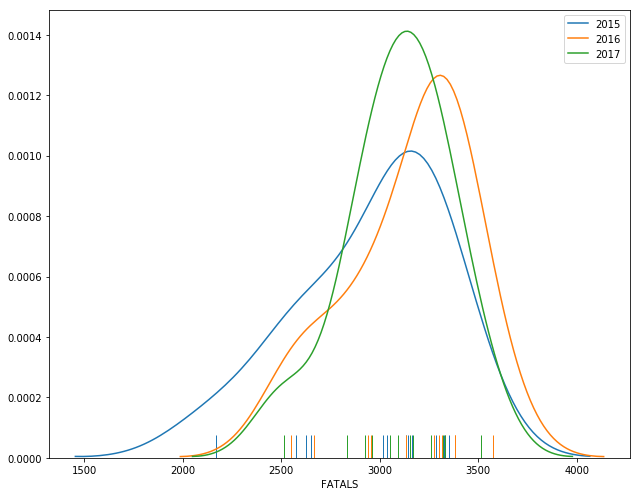

In [26]:
#plot a dist plot 
fig, ax = plt.subplots(figsize = (9,7))

sns.distplot(ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2015].FATALS, bins = 3, ax = ax, hist = False, rug = True, label = "2015")
sns.distplot(ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2016].FATALS, bins = 3, ax = ax, hist = False, rug = True, label = "2016")
sns.distplot(ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2017].FATALS, bins = 3, ax = ax, hist = False, rug = True, label = "2017")

plt.legend(loc = "best")
plt.tight_layout()
plt.savefig(os.path.join(images_dir, "Fatality_Monthly_dist.png"))

In [ ]:
with sns.color_palette(n_colors = 3):
    fig, axs = plt.subplots(1, 3, figsize = (20, 7))
    sns.regplot(x = 'MONTH', y= 'FATALS', data = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2015], ax = axs[0], color = '#0098BF')
    sns.regplot(x = 'MONTH', y= 'FATALS', data = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2016], ax = axs[1], color = '#99CC00')
    sns.regplot(x = 'MONTH', y= 'FATALS', data = ft_byMnth_Yr[ft_byMnth_Yr.YEAR == 2017], ax = axs[2], color = '#FF9900')
    
#     axs[0].set(xlabel='Atmospheric CO2 (ppm)', ylabel='Avg. Temperature (Deg C)')
#     axs[1].set(xlabel='Atmospheric Aerosol (per cubic cm)', ylabel='')
#     axs[2].set(xlabel='Total Solar Irradiance (watt per sq. m)', ylabel='')
    

plt.show()

In [ ]:
# Calculate Fatal accidents by month-year
ft_byWeek = accident_DF[["ACC_WEEK_NUM","FATALS"]].groupby(["ACC_WEEK_NUM"]).agg(np.sum)
ft_byWeek.reset_index(inplace = True)
ft_byWeek.head()

In [ ]:
sns.regplot(x = "ACC_WEEK_NUM", y = "FATALS", data = ft_byWeek)

In [ ]:
sns.distplot( ft_byWeek.FATALS, bins = 7)

In [ ]:
ft_var_week = variance(ft_byWeek.FATALS)
print(f"variance is {ft_var_week}")

ft_sd_week = standard_deviation(ft_byWeek.FATALS)
print(f"STD DEV is {ft_sd_week}")


In [ ]:
#Calc Std Dev, Variance